# 多种核技巧
---------------------------------

本脚本描述在TensorFlow中如何实现多种核技巧。


线性Kernel:

$$K(x_1, x_2) = x_1^{T} \cdot x_2$$

高斯Kernel (RBF):

$$K(x_1, x_2) = e^{(-\gamma |x_1 - x_2|^2)}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()

这里认为产生非线性数据。我们产生的数据是中心环数据。

In [3]:
# 生成非线性数据
(x_vals, y_vals) = datasets.make_circles(n_samples=350, factor=.5, noise=.1)
y_vals = np.array([1 if y==1 else -1 for y in y_vals])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

我们定义批数据数量，创建占位符，并且声明$b$变量（用于SVM模型）

- x_data : $x$
- y_target : $y$
- prediction_grid : $g$
- b : $b$

In [4]:
# 声明批数据尺寸
batch_size = 350

# 占位符
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# 创建变量
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

这里我们使用高斯核（注释部分是线性核）。如果选择使用线性核，可以把RBF核部分注释掉，并且使用`my_kernel`变量。

Tensorflow中的高斯核计算
- $\gamma = -50.0$，这是个常数
- 距离计算
    - $x_{ij}^2$
    - $dist_i = \sum_{j=1}^N x_{ij}^2$，其中$x \in R^{M \times N}$
    - $sq\_dists = dist - 2xx^T + dist^T$ (研究下广播机制)
    - $my\_kernel = exp(\gamma |sq\_dists|)$

In [5]:
# 应用核
# 线性核
# my_kernel = tf.matmul(x_data, tf.transpose(x_data))
tf.subtract
# Gaussian (RBF) 技巧
# 这里的计算是把平方函数打开之后进行计算！为了代码实现方便！
gamma = tf.constant(-50.0)
dist = tf.reduce_sum(tf.square(x_data), 1)    # 按列进行均方计算
dist = tf.reshape(dist, [-1,1])
sq_dists = tf.add(tf.subtract(dist, 
                              tf.multiply(2., 
                                          tf.matmul(x_data, tf.transpose(x_data)))), 
                  tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dists)))

- $first\_term = \frac {1}{batch} \sum_{i} b_i$
- $b\_vec\_cross = b^T \cdot b$
- $y\_target\_cross = y\_target \cdot y\_target^T$
- $my\_kernel \cdot b\_vec\_cross \cdot y\_target\_cross$取均值
- $loss = - (first\_term - second\_term)$

In [6]:
# 计算SVM模型
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, 
                                        tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

正如为了训练，我们创建核。我们也需要为测试/预测创建核。

再次，注释/反注释适当的行来进行线性核和RBF核的切换。

In [7]:
# 创建预测核
# 线性预测核
# my_kernel = tf.matmul(x_data, tf.transpose(prediction_grid))

# Gaussian (RBF)预测核
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, 
                                  tf.multiply(2., 
                                              tf.matmul(x_data, 
                                                        tf.transpose(prediction_grid)))), 
                      tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

为了使用核技巧来分类数据点，我们创建一个预测运算。该预测运算是模型输出的符号。和实际的目标标签进行比较计算出模型准确率。

In [8]:
prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), 
                                           tf.squeeze(y_target)), 
                                  tf.float32))

In [9]:
# 优化器
my_opt = tf.train.GradientDescentOptimizer(0.002)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

我们开始训练。

In [10]:
# 循环
loss_vec = []
batch_accuracy = []
for i in range(1000):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%250==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #250
Loss = 18.654394
Step #500
Loss = -3.834074
Step #750
Loss = -12.22615
Step #1000
Loss = -11.701718


画出匹配的结果。

In [11]:
# 创建一个mesh，来画出点
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

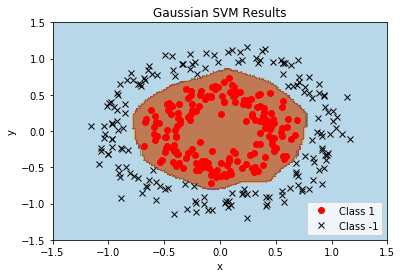

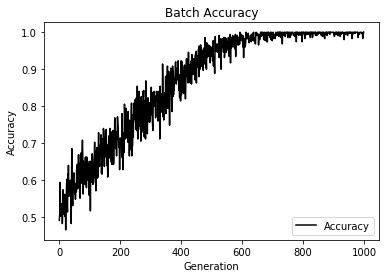

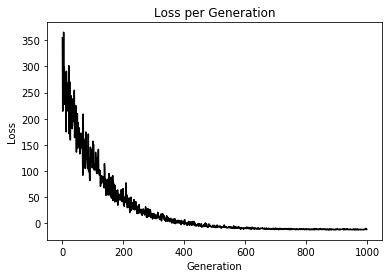

In [12]:
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='Class 1')
plt.plot(class2_x, class2_y, 'kx', label='Class -1')
plt.title('Gaussian SVM Results')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='lower right')
plt.ylim([-1.5, 1.5])
plt.xlim([-1.5, 1.5])
plt.show()

plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

## 预测/评估

这里的代码，显示如何预测新数据或未出现数据属于那个类。

In [13]:
# 新数据点
new_points = np.array([(-0.75, -0.75),
                       (-0.5, -0.5),
                       (-0.25, -0.25),
                       (0.25, 0.25),
                       (0.5, 0.5),
                       (0.75, 0.75)])

In [14]:
[evaluations] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                y_target: np.transpose([y_vals]),
                                                prediction_grid: new_points})

In [15]:
for ix, p in enumerate(new_points):
    print('{} : class={}'.format(p, evaluations[ix]))

[-0.75 -0.75] : class=-1.0
[-0.5 -0.5] : class=1.0
[-0.25 -0.25] : class=1.0
[0.25 0.25] : class=1.0
[0.5 0.5] : class=1.0
[0.75 0.75] : class=-1.0
